In [ ]:
from transformers import AutoModel, AutoTokenizer
kobert_tokenizer = AutoTokenizer.from_pretrained('skt/kobert-base-v1', use_fast=False)
kobert = AutoModel.from_pretrained('skt/kobert-base-v1')

result = kobert_tokenizer.tokenize('너는 내년 대선 때 투표할 수 있어?')
print(result)
kobert_vocab = kobert_tokenizer.get_vocab()
print(kobert_vocab.get('_대선'))
print([kobert_tokenizer.encode(token) for token in result])

['▁너', '는', '▁내년', '▁대선', '▁때', '▁투표', '할', '▁수', '▁있어', '?']
None
[[1457, 3, 2], [517, 5760, 3, 2], [1437, 3, 2], [1654, 3, 2], [1844, 3, 2], [4772, 3, 2], [4977, 3, 2], [2872, 3, 2], [3868, 3, 2], [633, 3, 2]]


In [ ]:
!python --version

Python 3.7.13


구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


파일 업로드 하기

In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-tugxm1sb
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-tugxm1sb


In [ ]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-hg8rux9g/kobert-tokenizer_5d3f74f103f640b4ba6bf135cffc63bb
  Running command git clone -q https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-hg8rux9g/kobert-tokenizer_5d3f74f103f640b4ba6bf135cffc63bb


In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==4.8.1
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sentencepiece
sentencepiece.__version__

'0.1.97'

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [ ]:
import transformers

In [ ]:
#kobert
# from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from kobert_tokenizer import KoBERTTokenizer

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup


In [ ]:
from transformers import BertModel

In [ ]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
torch.__version__

'1.12.0+cu113'

In [ ]:
#GPU 사용
device = torch.device("cuda:0")

In [ ]:
import pandas as pd
train_data = pd.read_json('/content/gdrive/MyDrive/감성데이터/emotion_train_edit.json')
train_data.sample(n=10)

,sentence,emotion
24173,이 직무를 잘못 선택한 것 같아. 나랑 너무 안 맞아. 응. 내가 이 일을 시작할 ...,3
1827,볼펜으로 쓴 답을 수정해야 하는데 필통에 화이트가 없어서 당황스러웠어. 알고보니 집...,4
28666,친구들이 점점 많이 없어지는 것 같아. 다들 바쁘다 보니 점점 주변에 아무도 남지 ...,1
10475,나는 싫다고 말했는데 왜 자꾸 카톡방에 초대해서 성가시게 메시지를 보낼까? 너무 괴...,0
4309,부모님 말씀을 더 잘 들을 거야. 응. 우리 부모님은 너무 좋으신 분들이야.,5
37105,인슐린 주사를 맞으면서 살아가는 게 너무나 지쳐. 이제는 정말 다 포기하고 싶어져.,1
5384,출산한 뒤 남편의 돌변한 태도에 화가 나. 너무 화가 나서 남편에게 해코지하고 싶을...,0
23686,내일 친구 결혼식이 있는데 가야 할지 말아야 할지 못 정했어. 친하지도 않고 지난 ...,2
18922,결혼을 일찍 한 친구들 보면 아이 키우는 게 힘들어 보여. 자기 시간도 없이 오로지...,2
35530,왜 내 친구들 중 하나도 약속 시간을 맞춰서 오지 않는 걸까? 자주가 아니라 항상....,0


In [ ]:
len(train_data)

40827

In [ ]:
val_data = pd.read_json('/content/gdrive/MyDrive/감성데이터/emotion_validation_edit.json')
val_data.sample(n=10)

,sentence,emotion
2852,화가 나서 견딜 수가 없어. 결혼하는 조카한테 버젓한 선물 하나 못 하다니. 결국은...,0
4787,어제 엄마랑 싸웠는데 아직도 화해를 못 해서 힘들어. 우울한 일도 없는데 너무 우울하네.,1
3659,회사 상사의 태도 때문에 참을 수가 없어. 상사가 자기 잘못을 부당하게 아래 사람에...,0
2741,회사에 젊은 친구들이 많아지고 나는 점점 뒤쳐져만 가는 기분이야. 점점 설 자리가 ...,1
2667,남편이 불륜을 저지르다니 구역질이 나. 이 사람에 대한 신뢰가 사라졌어.,0
820,코골이가 심해져서 너무 걱정이 생겼어. 아내의 눈치가 보여 내 코골이 때문에 잠을 ...,4
5050,병원에 갔다 왔는데 앞으로 평생 약을 먹어야 한대. 너무 속상해. 약을 평생 먹어야...,1
1716,내가 지속적으로 맞고 있는 건 그저 그 애들의 즐거움일 뿐이야. 나한테는 상처인데....,3
4509,이따금 아내가 기척도 없이 자고 있을 때면 큰일이 난건 아닌지 놀라곤 해. 혹시라도...,2
4414,아이들이 괴롭혀서 울고 있어. 이런 내 상황에 눈물이 흐르네.,1


In [ ]:
len(val_data)

5122

In [ ]:
data_list = []
for s, label in zip(train_data['sentence'], train_data['emotion']):
  data = [] 
  data.append(s)
  data.append(str(label))
  data_list.append(data)

In [ ]:
for s, label in zip(val_data['sentence'], val_data['emotion']):
  data = [] 
  data.append(s)
  data.append(str(label))
  data_list.append(data)

In [ ]:
len(data_list)

45949

In [ ]:
data_list[0:5]

[['아내가 드디어 출산하게 되어서 정말 신이 나. 아 지금 정말 신이 나.', '5'],
 ['당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야. 건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.', '2'],
 ['고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워. 아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.',
  '4'],
 ['재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해. 퇴직 후 다시는 돈을 못 벌 줄 알았는데 이렇게 월급으로 가족에게 맛있는 밥을 살 수 있어서 너무 행복해.',
  '5'],
 ['빚을 드디어 다 갚게 되어서 이제야 안도감이 들어. 빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.', '5']]

입력 데이터셋을 토큰화 하기

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):
   
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
         

    def __len__(self):
        return (len(self.labels))

In [ ]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
# train & test 데이터로 나누기
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(data_list, test_size=0.25, shuffle=True, random_state=34)

In [ ]:
print(len(dataset_train))
print(len(dataset_test))

34461
11488


In [ ]:
tok=tokenizer.tokenize
data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test,0, 1, tok, vocab,  max_len, True, False)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


KoBert 학습모델 만들기

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=6,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:

#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()  # 다중분류를 위한 대표적인 loss func

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

KoBERT 모델 학습시키기

In [ ]:
train_history=[]
test_history=[]
loss_history=[]

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
         
        #print(label.shape,out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            # print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            # train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_history.append(train_acc / (batch_id+1))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_history.append(test_acc / (batch_id+1))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/539 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 train acc 0.8675438631565479


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/180 [00:00<?, ?it/s]

epoch 1 test acc 0.6894097222222222


  0%|          | 0/539 [00:00<?, ?it/s]

epoch 2 train acc 0.8753998464589597


  0%|          | 0/180 [00:00<?, ?it/s]

epoch 2 test acc 0.6941840277777778


  0%|          | 0/539 [00:00<?, ?it/s]

epoch 3 train acc 0.8916975881261595


  0%|          | 0/180 [00:00<?, ?it/s]

epoch 3 test acc 0.6857638888888888


  0%|          | 0/539 [00:00<?, ?it/s]

epoch 4 train acc 0.911490987460815


  0%|          | 0/180 [00:00<?, ?it/s]

epoch 4 test acc 0.6910590277777777


  0%|          | 0/539 [00:00<?, ?it/s]

epoch 5 train acc 0.9365143784786641


  0%|          | 0/180 [00:00<?, ?it/s]

epoch 5 test acc 0.68671875


  0%|          | 0/539 [00:00<?, ?it/s]

epoch 6 train acc 0.9615897495361782


  0%|          | 0/180 [00:00<?, ?it/s]

epoch 6 test acc 0.6920138888888889


  0%|          | 0/539 [00:00<?, ?it/s]

epoch 7 train acc 0.9744608070500927


  0%|          | 0/180 [00:00<?, ?it/s]

epoch 7 test acc 0.7013020833333333


  0%|          | 0/539 [00:00<?, ?it/s]

epoch 8 train acc 0.9803745361781077


  0%|          | 0/180 [00:00<?, ?it/s]

epoch 8 test acc 0.6964409722222222


  0%|          | 0/539 [00:00<?, ?it/s]

epoch 9 train acc 0.9773017161410018


  0%|          | 0/180 [00:00<?, ?it/s]

epoch 9 test acc 0.6850694444444444


  0%|          | 0/539 [00:00<?, ?it/s]

epoch 10 train acc 0.9672135899814471


  0%|          | 0/180 [00:00<?, ?it/s]

epoch 10 test acc 0.6873263888888889


새로운 문장 테스트

In [ ]:
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("분노가")
            elif np.argmax(logits) == 1:
                test_eval.append("슬픔이")
            elif np.argmax(logits) == 2:
                test_eval.append("불안이")
            elif np.argmax(logits) == 3:
                test_eval.append("상처가")
            elif np.argmax(logits) == 4:
                test_eval.append("당황이")
            elif np.argmax(logits) == 5:
                test_eval.append("기쁨이")

        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

In [ ]:
#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == '0' :
        break
    predict(sentence)
    print("\n")


하고싶은 말을 입력해주세요 : 아 배고파


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


>> 입력하신 내용에서 분노가 느껴집니다.


하고싶은 말을 입력해주세요 : 걘 진짜 그럴 줄 알았다.
>> 입력하신 내용에서 슬픔이 느껴집니다.


하고싶은 말을 입력해주세요 : 부모님이랑 싸웠어.
>> 입력하신 내용에서 상처가 느껴집니다.


하고싶은 말을 입력해주세요 : 내 자신이 너무 좋아. 은빈아 잘했어.
>> 입력하신 내용에서 기쁨이 느껴집니다.


하고싶은 말을 입력해주세요 : 오빠가 날 안좋아 하는 것 같아.
>> 입력하신 내용에서 슬픔이 느껴집니다.




KeyboardInterrupt: ignored

In [ ]:
train_history

[0.8675438631565479,
 0.8753998464589597,
 0.8916975881261595,
 0.911490987460815,
 0.9365143784786641,
 0.9615897495361782,
 0.9744608070500927,
 0.9803745361781077,
 0.9773017161410018,
 0.9672135899814471]

In [ ]:
test_history

[0.6894097222222222,
 0.6941840277777778,
 0.6857638888888888,
 0.6910590277777777,
 0.68671875,
 0.6920138888888889,
 0.7013020833333333,
 0.6964409722222222,
 0.6850694444444444,
 0.6873263888888889]

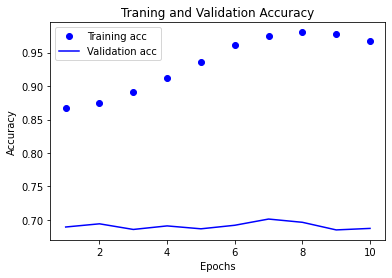

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 11)

plt.clf()
plt.plot(epochs, train_history, 'bo', label='Training acc')
plt.plot(epochs, test_history, 'b', label='Validation acc')
plt.title('Traning and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()